# Обучение модели на отобранных признаках

## 1 Импорт библиотек, инициализация глобальных констант

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
import joblib

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
from lightgbm import log_evaluation
import shap

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

### 1.2 Инициализация констант

In [2]:
# целевая переменная
TARGET_NAME = 'Цена_квм'
# размер отложенной выборки
TEST_SIZE = 0.15
# random state для воспроизводимости
RANDOM_STATE = 42

## 2 Подготовка данных

In [3]:
df = pd.read_csv('houseprices_final.csv')
metros = pd.read_csv('metro_coords.csv')
df.head()

,ID,Ссылка,Цена,Дата,Адрес,Этаж,Количество_комнат,Балкон_или_лоджия,Тип_комнат,Общая_площадь,Жилая_площадь,Площадь_кухни,Высота_потолков,Санузел,Ремонт,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Метро_1,Метро_2,Метро_3,Расстояние_до_метро_1,Расстояние_до_метро_2,Расстояние_до_метро_3,Широта,Долгота,Ипотека,Расстояние_до_Кремля,Окна_на_улицу,Окна_во_двор,Окна_на_солнечную_сторону,Мебель_спальные_места,Мебель_кухня,Мебель_хранение_одежды,В_доме_мусоропровод,В_доме_консьерж,В_доме_газ,Двор_закрытая_территория,Двор_спортивная_площадка,Двор_детская_площадка,Парковка,Количество_лифтов,Цена_квм,Район,Общий_рейтинг,Экология,Чистота,ЖКХ,Соседи,Условия_для_детей,Спорт_и_отдых,Магазины,Транспорт,Безопасность,Стоимость_жизни,Суммарный рейтинг,Общая_площадь_отн_мин,Общая_площадь_минус_мин,Общая_площадь_отн_макс,Общая_площадь_минус_макс,Общая_площадь_отн_сред,Общая_площадь_минус_сред,Расстояние_до_Парк_культуры,Расстояние_до_Октябрьская,Расстояние_до_Добрынинская,Расстояние_до_Павелецкая,Расстояние_до_Таганская,Расстояние_до_Красные_ворота,Расстояние_до_Проспект_Мира,Расстояние_до_Курская,Расстояние_до_Белорусская,Расстояние_до_Новослободская,Расстояние_до_Киевская,Расстояние_до_Краснопресненская,Общая_площадь_кластер,Координаты_кластер
0,2636072348,https://avito.ru//moskva/kvartiry/3-k._kvartir...,33000000,2022-12-02,"Москва, Ленинградское шоссе, 69к2",18.0,3.0,балкон,изолированные,73.2,NaN,16.0,NaN,NaN,0.0,3.0,NaN,20.0,0,0,Беломорская,Речной вокзал,Планерная,30.0,30.0,31.0,55.868713,37.456819,0,16.417191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,450819.672131,45.0,39.0,39.0,84.0,65.0,38.0,44.0,40.0,102.0,81.0,17.0,23.0,572.0,1.763855,31.7,0.281538,-186.8,0.873901,-10.562326,17.083389,18.258180,18.672102,19.183695,18.657365,16.339909,14.839579,17.596692,12.816081,13.400078,15.492292,14.198571,8,40
1,2626697262,https://avito.ru//moskva/kvartiry/3-k._kvartir...,39000000,2022-12-03,"Москва, Ходынская улица, 2",13.0,3.0,NaN,изолированные,73.7,50.0,15.0,NaN,совмещенный,0.0,3.0,NaN,44.0,0,0,Улица 1905 года,Беговая,Белорусская,1905.0,20.0,20.0,55.770949,37.563930,0,3.971249,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,529172.320217,77.0,62.0,93.0,45.0,67.0,16.0,85.0,52.0,109.0,40.0,10.0,79.0,658.0,1.775904,32.2,0.283462,-186.3,0.879871,-10.062326,4.329917,5.493617,5.934142,6.548749,6.432229,5.254251,4.464546,6.107069,1.346540,2.524840,3.094803,1.435916,8,124
2,2658691692,https://avito.ru//moskva/kvartiry/3-k._kvartir...,22500000,2022-12-05,"Москва, Аминьевское ш., 4Дк3литБ",9.0,3.0,лоджия,изолированные,69.3,43.9,5.7,3.0,раздельный,3.0,3.0,2022.0,28.0,2,2,Аминьевская,Давыдково,Мичуринский проспект,15.0,30.0,31.0,55.698791,37.468364,1,11.067722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,1.0,1.0,4,324675.324675,72.0,93.0,76.0,62.0,62.0,76.0,88.0,112.0,96.0,107.0,77.0,94.0,943.0,1.669880,27.8,0.266538,-190.7,0.827341,-14.462326,8.955781,9.558359,10.224293,11.210438,12.558108,13.636461,13.702383,13.664497,11.277326,12.245417,7.763103,9.657269,8,11
3,2515435010,https://avito.ru//moskva/kvartiry/3-k._kvartir...,17900000,2022-12-05,"Москва, Севастопольский пр-т, 13к2",5.0,3.0,лоджия,изолированные,62.5,45.0,7.0,2.8,совмещенный,1.0,4.0,1979.0,9.0,1,0,Крымская,Верхние Котлы,Нагатинская,15.0,20.0,20.0,55.683567,37.602962,0,7.665333,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1,286400.000000,38.0,53.0,36.0,22.0,53.0,78.0,62.0,71.0,37.0,16.0,47.0,113.0,588.0,1.506024,21.0,0.240385,-197.5,0.746159,-21.262326,5.869496,5.106472,5.197940,5.601104,7.262720,9.832084,10.848071,9.048621,10.519448,10.679586,7.054251,8.693040,0,10
4,1972516369,https://avito.ru//moskva/kvartiry/10_i_bolee-k...,525000000,2022-12-05,"Москва, Пресненская набережная, 6с2",59.0,1.0,NaN,изолированные,941.7,NaN,20.0,NaN,NaN,2.0,3.0,2010.0,60.0,1,0,Деловой центр,Выставочная,Международная,5.0,5.0,10.0,55.748071,37.540397,0,4.859495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,557502.389296,77.0,62.0,93.0,45.0,67.0,16.0,85.0,52.0,109

### 2.1 Кодирование станций метро

In [4]:
metro_stations = np.append(metros['Станция'].values, ['нет'])

le = LabelEncoder()

le.fit(metro_stations.reshape(-1, 1))
for i in range(1, 4):
    df[f'Метро_{i}'] = le.transform(df[f'Метро_{i}'])
# сохраняем
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
with open("metro_stations.pkl", "wb") as f:
    pickle.dump(le_dict, f)

### 2.2 Кодирование категориальных переменных

In [5]:
cat_features = ['Район', 'Количество_комнат', 'Ремонт', 'Тип_дома']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[cat_features] = encoder.fit_transform(df[cat_features])
# сохраняем
with open("categorical_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

### 2.3 Отложенная выборка

In [6]:
train, test = train_test_split(df,
                               test_size=TEST_SIZE,
                               stratify=df['Количество_комнат'],
                               random_state=RANDOM_STATE)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## 3 Обучение модели

### 3.1 Функция для обучения и получения предсказаний

In [7]:
def lgb_training(train_df, params, features, test_df=None, verbose=250):
    """
    Функция для обучения модели.
    
    Параметры
    ----------
    train_df - обучающая выборка
    params - набор гиперпараметров
    features - признаки
    test_df - тестовая выборка
    verbose - вывод результатов
    
    Возвращает
    -------
    score_list - MAPE на кросс-валидации для каждого фолда
    test_preds - предсказания на тестовой выборке, если тестовая выборка задана
    oof_preds - предсказания для обучающей выборки
    models - список обученных моделей
    """
    test_preds = []
    if test_df is not None:
        test_preds = np.zeros(len(test_df))
        test_df = test_df[features]
    target = train_df.loc[:, TARGET_NAME].values

    categorical_feature = list(set(features) & set(cat_features))
    models = []
    score_list = []
    oof_preds = np.zeros(len(target))

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
        X_train = train_df.loc[train_index, features]
        X_val = train_df.loc[val_index, features]
        y_train = target[train_index]
        y_val = target[val_index]

        lgb_train = lgb.Dataset(X_train,
                                y_train,
                                categorical_feature=categorical_feature)
        lgb_valid = lgb.Dataset(X_val,
                                y_val,
                                categorical_feature=categorical_feature)

        callbacks = [lgb.log_evaluation(period=verbose)]
        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=15000,
                          valid_sets=[lgb_train, lgb_valid],
                          categorical_feature=categorical_feature,
                          callbacks=callbacks)

        preds = model.predict(X_val)
        oof_preds[val_index] = preds
        score = mean_absolute_percentage_error(y_val, preds)

        if test_df is not None:
            test_preds += model.predict(test_df) / kf.n_splits

        if verbose:
            print(
                f"{Fore.BLACK}{Style.BRIGHT}FOLD: {fold}, MAPE: {score:.5f} {Style.RESET_ALL}"
            )
        score_list.append(score)

        models.append(model)

    return score_list, test_preds, oof_preds, models

### 3.2 Гиперпараметры
По сравнению с бейзлайном немного уменьшил learning_rate

In [8]:
params = {
    'objective': 'mape',
    'learning_rate': 0.25,
    'reg_lambda': 5,
    'random_state': 42,
    'early_stopping_rounds': 300,
    'feature_fraction': 0.4,
    'verbose': -1
}

### 3.3 Отобранные признаки
Признаки адрес, этаж, количество комнат, общая площадь, этаж, количество этажей в доме есть в каждом объявлении, поэтому решено было получать их от пользователя.

На основе важности функций на основе перестановки определил наиболее важные созданные признаки

In [9]:
features = [
    'Район', 'Количество_комнат', 'Общая_площадь', 'Ремонт', 'Этаж',
    'Этажей_в_доме', 'Тип_дома', 'Расстояние_до_Краснопресненская',
    'Координаты_кластер', 'Метро_1', 'Метро_2', 'Метро_3',
    'Общая_площадь_минус_мин', 'Расстояние_до_Кремля', 'Расстояние_до_Киевская'
]

### 3.4 Обучение, сохранение моделей

In [10]:
score_list, test_preds, oof_preds, models = lgb_training(train,
                                                         params,
                                                         features,
                                                         test,
                                                         verbose=500)
test_score = mean_absolute_percentage_error(test[TARGET_NAME], test_preds)

print(f"{Fore.GREEN}{Style.BRIGHT}\nMAPE на кросс-валидации:", end=' ')
print(f"{np.mean(score_list):.5f} +- {np.std(score_list):.5f}")

print(f"{Fore.RED}MAPE на тестовой выборке: {test_score:.5f}{Style.RESET_ALL}")

[500]	training's mape: 0.0915447	valid_1's mape: 0.139153
[1000]	training's mape: 0.0812303	valid_1's mape: 0.137525
[1500]	training's mape: 0.0751864	valid_1's mape: 0.136739
[2000]	training's mape: 0.0710623	valid_1's mape: 0.136223
[2500]	training's mape: 0.0685061	valid_1's mape: 0.135915
[3000]	training's mape: 0.0666421	valid_1's mape: 0.135722
[3500]	training's mape: 0.0652275	valid_1's mape: 0.135722
FOLD: 0, MAPE: 0.13567 
[500]	training's mape: 0.0936801	valid_1's mape: 0.137942
[1000]	training's mape: 0.0815522	valid_1's mape: 0.135605
[1500]	training's mape: 0.0757004	valid_1's mape: 0.134854
[2000]	training's mape: 0.0722516	valid_1's mape: 0.134344
[2500]	training's mape: 0.0694795	valid_1's mape: 0.133946
[3000]	training's mape: 0.0676279	valid_1's mape: 0.133571
[3500]	training's mape: 0.0659377	valid_1's mape: 0.133267
[4000]	training's mape: 0.0645143	valid_1's mape: 0.133098
[4500]	training's mape: 0.0633123	valid_1's mape: 0.132998
[5000]	training's mape: 0.0624014	

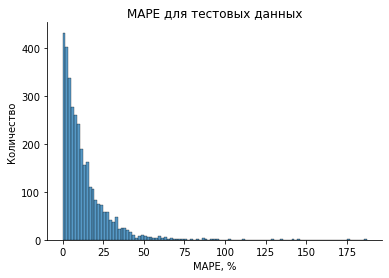

In [11]:
sns.histplot(np.abs(test[TARGET_NAME] - test_preds) / test[TARGET_NAME] * 100)
plt.title("MAPE для тестовых данных")
plt.xlabel("MAPE, %")
plt.ylabel("Количество")
sns.despine()
plt.show()

### 3.5 Сохранение
Возможно 2 подхода:
*  использовать 5 моделей, каждая из которых обучалась на 80% тренировочных данных
*  обучить 1 модель на всей тренировочной выборке

Посмотрим ошибку на тренировочной выборке при 2 способе. Для этого обучим зададим количество итераций, равное медиане лучших итерации на каждом фолде


In [12]:
iterations = [model.best_iteration for model in models]
n_iter = int(np.median(iterations)) + 1
print('Лучшая итерация для каждого фолда:')
print(iterations)

Лучшая итерация для каждого фолда:
[3376, 8151, 3307, 4556, 4386]


In [13]:
params['metric'] = None
params['early_stopping_rounds'] = None

model = lgb.train(params=params,
                  train_set=lgb.Dataset(train[features], train[TARGET_NAME]),
                  num_boost_round=n_iter,
                  categorical_feature=cat_features,
                  callbacks=[lgb.log_evaluation(period=0)])

test_preds=model.predict(test[features])
test_score=mean_absolute_percentage_error(test[TARGET_NAME],test_preds)
print(f"{Fore.RED}{Style.BRIGHT}MAPE на тестовой выборке: {test_score:.5f}{Style.RESET_ALL}")

MAPE на тестовой выборке: 0.12997


MAPE при таком способе оказалась выше на 0.002 по сравнению с первым способом. Думаю, это связано с тем, что предсказания моделей, обученных на 80% тренировочных данных (4 фолдах) хоть сколько-то некоррелированы, благодаря чему при усреднении удается снизить ошибку за счет уменьшения разброса

In [14]:
# сохранение
for fold in range(5):
    joblib.dump(models[fold], f'lgb_model_{fold}')

### 3.6 Эксперименты над улучшением модели


Для каждого примера из тренировочной выборки посчитаем значение ошибки на кросс-валидации

In [15]:
train['MAPE'] = np.abs(train[TARGET_NAME] - oof_preds) / train[TARGET_NAME]

train.sort_values(by='MAPE', ascending=False).head(10)

,ID,Ссылка,Цена,Дата,Адрес,Этаж,Количество_комнат,Балкон_или_лоджия,Тип_комнат,Общая_площадь,Жилая_площадь,Площадь_кухни,Высота_потолков,Санузел,Ремонт,Тип_дома,Год_постройки,Этажей_в_доме,Пассажирский_лифт,Грузовой_лифт,Метро_1,Метро_2,Метро_3,Расстояние_до_метро_1,Расстояние_до_метро_2,Расстояние_до_метро_3,Широта,Долгота,Ипотека,Расстояние_до_Кремля,Окна_на_улицу,Окна_во_двор,Окна_на_солнечную_сторону,Мебель_спальные_места,Мебель_кухня,Мебель_хранение_одежды,В_доме_мусоропровод,В_доме_консьерж,В_доме_газ,Двор_закрытая_территория,Двор_спортивная_площадка,Двор_детская_площадка,Парковка,Количество_лифтов,Цена_квм,Район,Общий_рейтинг,Экология,Чистота,ЖКХ,Соседи,Условия_для_детей,Спорт_и_отдых,Магазины,Транспорт,Безопасность,Стоимость_жизни,Суммарный рейтинг,Общая_площадь_отн_мин,Общая_площадь_минус_мин,Общая_площадь_отн_макс,Общая_площадь_минус_макс,Общая_площадь_отн_сред,Общая_площадь_минус_сред,Расстояние_до_Парк_культуры,Расстояние_до_Октябрьская,Расстояние_до_Добрынинская,Расстояние_до_Павелецкая,Расстояние_до_Таганская,Расстояние_до_Красные_ворота,Расстояние_до_Проспект_Мира,Расстояние_до_Курская,Расстояние_до_Белорусская,Расстояние_до_Новослободская,Расстояние_до_Киевская,Расстояние_до_Краснопресненская,Общая_площадь_кластер,Координаты_кластер,MAPE
79,2900637316,https://avito.ru//moskva/kvartiry/2-k._kvartir...,8200000,2023-01-08,"Москва, Манежная пл.",1.0,2.0,лоджия,"изолированные, смежные",65.0,25.0,15.0,NaN,совмещенный,1.0,3.0,2016.0,13.0,1,1,141,200,156,5.0,5.0,5.0,55.756081,37.615960,0,0.467282,1.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2,126153.846154,95.0,52.0,99.0,19.0,22.0,2.0,75.0,73.0,112.0,58.0,5.0,86.0,603.0,2.500000,39.0,0.369318,-111.0,1.169438,9.417735,2.573275,2.997723,3.039914,3.256229,2.790393,2.411647,2.837923,2.709527,3.181909,2.772928,3.549396,2.477028,0,106,3.233999
16061,2745622557,https://avito.ru//moskva/kvartiry/2-k._kvartir...,6775500,2023-01-06,"Москва, Большая Дорогомиловская ул., 4",4.0,2.0,NaN,изолированные,54.3,NaN,11.0,NaN,совмещенный,1.0,1.0,1955.0,8.0,0,0,70,184,186,5.0,15.0,15.0,55.745995,37.570680,1,3.019494,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,124779.005525,26.0,99.0,112.0,65.0,57.0,29.0,110.0,110.0,114.0,69.0,15.0,105.0,885.0,2.088462,28.3,0.308523,-121.7,0.976930,-1.282265,1.875591,3.138074,3.756405,4.625379,5.188799,5.425811,5.428339,5.703175,3.568751,4.198332,0.519980,1.649215,0,99,2.677229
286,2745015462,https://avito.ru//moskva/kvartiry/2-k._kvartir...,6655000,2023-01-06,"Москва, Кутузовский пр-т, 4/2",7.0,2.0,NaN,изолированные,54.1,NaN,11.0,NaN,совмещенный,1.0,1.0,1957.0,10.0,0,0,70,47,184,15.0,20.0,20.0,55.750732,37.562272,1,3.473607,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,123012.939002,26.0,99.0,112.0,65.0,57.0,29.0,110.0,110.0,114.0,69.0,15.0,105.0,885.0,2.080769,28.1,0.307386,-121.9,0.973332,-1.482265,2.612979,3.875698,4.480174,5.322763,5.774142,5.696810,5.498006,6.117366,3.218496,4.031664,0.854714,1.418773,0,99,2.389221
11505,2858503292,https://avito.ru//moskva/kvartiry/2-k._kvartir...,7844000,2023-01-09,"Москва, Головинское ш., 10Б",8.0,2.0,NaN,изолированные,64.8,NaN,12.0,NaN,совмещенный,1.0,3.0,2019.0,36.0,0,0,40,14,77,10.0,30.0,30.0,55.837181,37.497324,1,12.098234,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0,121049.382716,21.0,26.0,14.0,77.0,40.0,22.0,45.0,49.0,31.0,44.0,30.0,26.0,404.0,2.492308,38.8,0.368182,-111.2,1.165839,9.217735,12.786255,13.948530,14.353093,14.861392,14.360023,12.128098,10.657423,13.363689,8.496967,9.119245,11.262501,9.889615,0,83,2.039575
12037,2719392666,https://avito.ru//moskva/kvartiry/apartamenty-...,2250000,2023-01-11,"Москва, 1-й Колобовский пер., 13/14/2с4",1.0,11.0,NaN,NaN,13.0,10.0,NaN,2.5,совмещенный,2.0,1.0,1917.0,3.0,0,0,208,234,237,10.0,10.0,10.0,55.769249,37.617126,0,1.918485,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,173076.923077,95.0,52.0,99.0,19.0,22.0,2.0,75.0,73.0,112.0,58.0,5.0,86.0,603.0,1.300000,3.0,0.206349,-50.0,0.672078,-6.342979,3.930321,4.462363,4.488918,4.59

Попробуем заново обучить модель, предварительно удалив из обучающей выборки объявления, ошибка на которых больше определенного порога

In [16]:
THRESHOLDS = [0.8, 0.9, 1, 1.2, 1.5]
for thr in THRESHOLDS:
    tmp_train = train.loc[train['MAPE'] < thr].reset_index(drop=True)
    score_list, test_preds, _, _ = lgb_training(tmp_train,
                                                params,
                                                features,
                                                test,
                                                verbose=0)
    test_score = mean_absolute_percentage_error(test[TARGET_NAME], test_preds)

    print(f"{Fore.BLACK}{Style.BRIGHT}Порог для удаления: {thr*100:.0f}%")
    print(f"{Fore.GREEN}{Style.BRIGHT}MAPE на кросс-валидации:", end=' ')
    print(f"{np.mean(score_list):.5f} +- {np.std(score_list):.5f}")

    print(
        f"{Fore.RED}MAPE на тестовой выборке: {test_score:.5f}{Style.RESET_ALL}"
    )
    print()

Порог для удаления: 80%
MAPE на кросс-валидации: 0.12662 +- 0.00119
MAPE на тестовой выборке: 0.12753

Порог для удаления: 90%
MAPE на кросс-валидации: 0.12733 +- 0.00202
MAPE на тестовой выборке: 0.12765

Порог для удаления: 100%
MAPE на кросс-валидации: 0.12982 +- 0.00107
MAPE на тестовой выборке: 0.12731

Порог для удаления: 120%
MAPE на кросс-валидации: 0.13179 +- 0.00200
MAPE на тестовой выборке: 0.12634

Порог для удаления: 150%
MAPE на кросс-валидации: 0.13214 +- 0.00257
MAPE на тестовой выборке: 0.12663



## 4 Важность признаков и интерпретация предсказаний

In [17]:
explainer = shap.TreeExplainer(models[4])
shap_values = explainer(test[features])

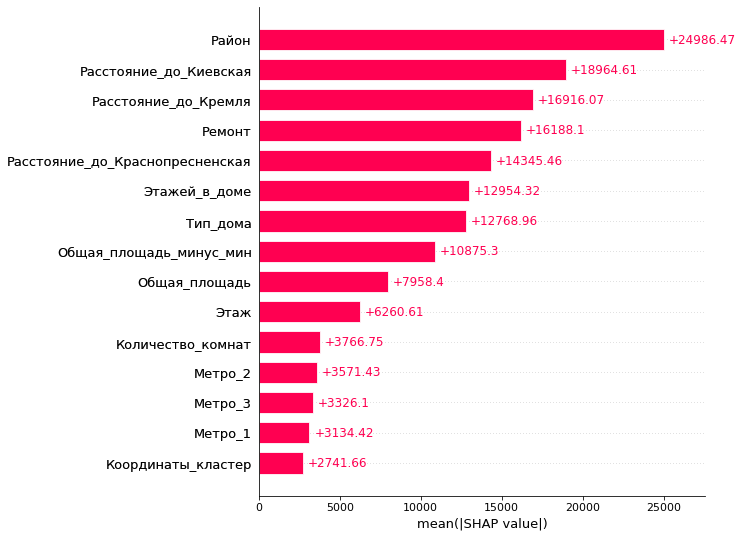

In [18]:
shap.plots.bar(shap_values, max_display=None)

Самым важным, как и при permutation importance, оказался Район. Как было выяснено в ходе разведывательного анализа данных, количество комнат слабо влияет на стоимость квадратного метра, что и видно на графике

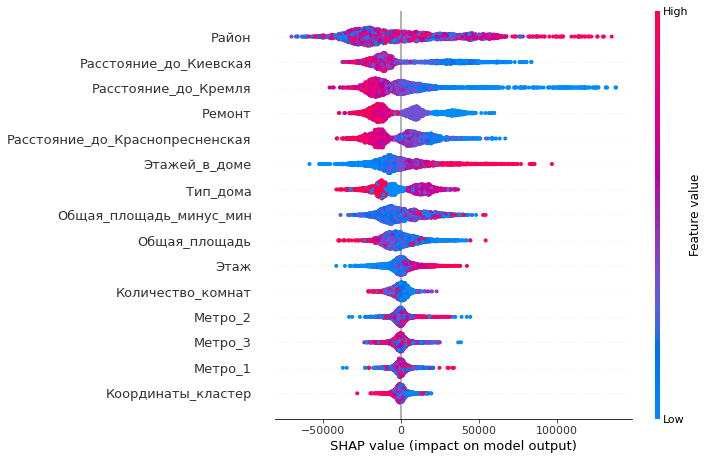

In [19]:
shap.plots.beeswarm(shap_values, max_display=None)

Можно сделать следующие выводы:
*  чем дальше от Кремля находится квартира, тем дешевле стоимость квадратного метра
*  чем дальше от метро Киевская находится квартира, тем дешевле стоимость квадратного метра. Возможно, здесь важно учесть, что Киевская ближе всего к Москва-Сити (это подтверждает тот факт, что для модели так же важно и расстояние до метро Краснопресненская) или к Арбату
*  чем больше этажей в доме, тем дороже стоимость квадратного метра. Я посмотрел [список самих высоких зданий Москвы](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D1%85_%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B) и почти во всех из них продается элитное жилье
*  чем ниже этаж на котором расположена квартира, тем дешевле стоимость квадратного метра. [Возможно](https://realty.rbc.ru/news/577d242c9a7947a78ce91b8b) это связано с тем, что традиционно стоимость квадратного метра на первом этаже всегда ниже, чем в среднем по дому.